# **project 5 - part A**

Guy Hadad 316508126

Noam Shamir 316299098

?כיצד מתפלג מדד הגלוקוז בקרב מעשנים לעומת ההתפלגות בקרב לא מעשנים


Question 1

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import math

In [ ]:
df_full = pd.read_csv('framingham_heart_disease.csv')

In [ ]:
def sample_rows(df_full, size=200):
      return df_full.sample(n=size, random_state=0)

In [ ]:
df = sample_rows(df_full)

In [ ]:
df.dropna(how='any', subset=['glucose','currentSmoker'], inplace=True)
#183 rows remain!

df = df[['glucose','currentSmoker']]

glucose =  df['glucose'].to_numpy()
smoker = df['currentSmoker'].to_numpy()

In [ ]:
duplicate_df = df_full.copy() #4219
# print(duplicate_df)
for index_to_delete in df.index:
  duplicate_df.drop(index_to_delete, inplace=True)
# print(duplicate_df)

In [ ]:
df_1000 = sample_rows(duplicate_df, size=1000)

In [ ]:
df_1000.dropna(how='any', subset=['glucose','currentSmoker'], inplace=True)
#885 rows remain!
df_1000 = df_1000[['glucose','currentSmoker']]

Question 2

In [ ]:
tau = glucose.mean()
# tau = 80.37
df['z'] = np.where(df['glucose']>tau, 1, 0)
df_1000['z'] = np.where(df_1000['glucose']>tau, 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Question 2. a

In [ ]:
def probability_z1(df, to_print=True):
  # p_z1_smoke = probability of z=1 given current Smoker
  # p_z1_no_smoke = probability of z=1 given is not current Smoker
  df_do_smoke = df[df['currentSmoker']==1]
  p_z1_smoke = df_do_smoke["z"].mean()
  df_doesnt_smoke = df[df['currentSmoker']==0]
  p_z1_no_smoke = df_doesnt_smoke["z"].mean()
  if to_print:
    print("probability of z=1 given current Smoker:")
    print(round(p_z1_smoke,2))
    print("probability of z=1 given is not current Smoker")
    print(round(p_z1_no_smoke,2))
  return round(p_z1_smoke,2), round(p_z1_no_smoke,2)

In [ ]:
p_z1_smoke, p_z1_no_smoke = probability_z1(df,True)

probability of z=1 given current Smoker:
0.37
probability of z=1 given is not current Smoker
0.47


In [ ]:
def eta(p):
    return math.log(p/(1-p))

In [ ]:
psi = eta(p_z1_smoke)-eta(p_z1_no_smoke)
print("Psi value is:", round(psi,3))

Psi value is: -0.412


In [ ]:
#Bootstrap
B=400
B_sample_size = len(df) #Actually its 181 and not 200 because of missing data.
boot_psi =[]

for j in range(B):
    boot_samp = df.sample(B_sample_size, replace=True, random_state=j) #The result with random_state=j and without it were quite same
    boot_p_z1_smoke, boot_p_z1_no_smoke = probability_z1(boot_samp,to_print=False)
    boot_psi.append(eta(boot_p_z1_smoke)-eta(boot_p_z1_no_smoke))
 
    
alpha = 0.05
boot_psi.sort()
first_quantile = boot_psi[int(B*alpha/2)]
second_quantile =  boot_psi[int(B*(1-alpha/2))]
ci =[round(first_quantile,3), round(second_quantile,3)]

print ("Psi value is: ", round(psi,3))
print("CI for Psi (with quantiles method) is: ",ci )

Psi value is:  -0.412
CI for Psi (with quantiles method) is:  [-1.002, 0.165]


We got Psi value of -0.412.
Applying exp(-0.412) will lead to conclude that Odds Ratio is 2.43

מסקנה:
ניתן היה לחשוב שבקרב מעשנים הסיכוי לגלוקוז גבוה הוא פי 2.3 אך נשים לב שרווח הסמך מכיל את 0 ולכן לא ניתן לומר ברמת מובהקות אלפא 0.05 שקיים הבדל ברמות הגלוקוז (גבוה/נמוך) בהנתן סטטוס העישון.



question 2. b

בהנחת הפריור היוניפורמי - הפוסטריור יתפלג בטא ולכן נוכל לאמוד את הפרמטרים של ההתפלגות ואז לדגום מהתפלגות בטא 

In [ ]:
#uniform prior --> posterior distribute beta: 

df_smoker = df[df['currentSmoker']==1]
df_no_smoker = df[df['currentSmoker']==0]

m = len(df_smoker)
n = len(df_no_smoker)
s_smoker = len(df_smoker[df_smoker['z']==1])

alpha_smoker = s_smoker + 1
beta_smoker = m - s_smoker +1

s_no_smoker = len(df_no_smoker[df_no_smoker['z']==0])
alpha_no_smoker = s_no_smoker + 1
beta_no_smoker = n - s_no_smoker + 1

#expectation of Beta distribution
baysian_p_z1_smoke = alpha_smoker/(alpha_smoker + beta_smoker)
baysian_p_z1_no_smoke = alpha_no_smoker/(alpha_no_smoker + beta_no_smoker)

baysian_psi = eta(baysian_p_z1_smoke) - eta(baysian_p_z1_no_smoke)

#CI
boot_psi =[]
B=400
alpha = 0.05
for i in range(B):
    boot_p_smoker_2 = np.random.beta(alpha_smoker, beta_smoker)
    boot_p_no_smoker_2 = np.random.beta(alpha_no_smoker, beta_no_smoker)
    psi_2 = eta(boot_p_smoker_2) - eta(boot_p_no_smoker_2)
    boot_psi.append(psi_2)

boot_psi.sort()
first_quantile = boot_psi[int(B*alpha/2)]
second_quantile =  boot_psi[int(B*(1-alpha/2))]
ci_2 =[round(first_quantile,3), round(second_quantile,3)]

print("Baysian method. Results:")
print ("Psi value is: ", round(baysian_psi,3))
print("CI for Psi (with quantiles method) is: ",ci_2)

Baysian method. Results:
Psi value is:  -0.644
CI for Psi (with quantiles method) is:  [-1.213, -0.022]


רווח הסמך אינו כולל את ה0 והמסקנה היא שבטכניקה הבייסיאנית אכן קיבלנו תוצאה שבה קיים הבדל ברמת מובהקות אלפא = 0.05 ברמת הגלוקוז (גובה/נמוך) בקרב קבוצת המעשנים לעומת לא מעשנים.

question 2. c

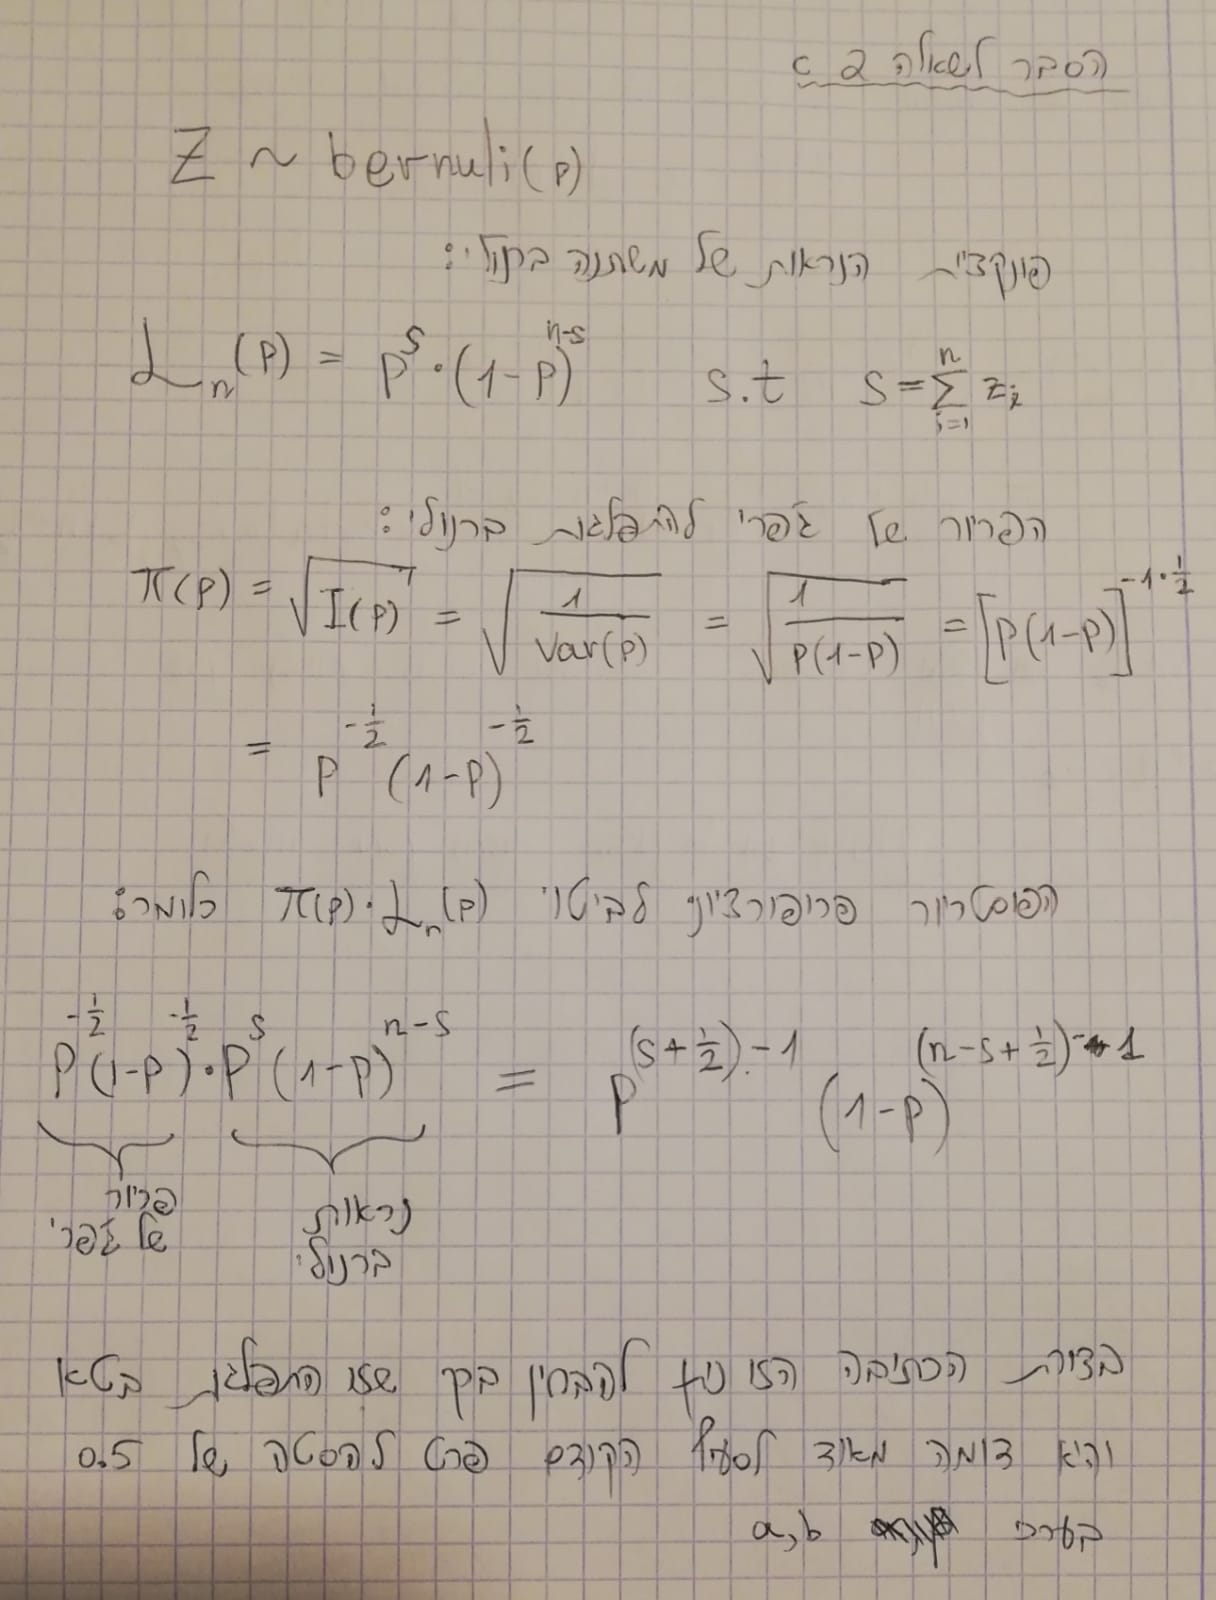

In [ ]:

alpha_smoker = s_smoker + 0.5
beta_smoker = m - s_smoker + 0.5

alpha_no_smoker = s_no_smoker + 0.5
beta_no_smoker = n - s_no_smoker + 0.5

#expectation of Beta distribution
baysian_p_z1_smoke = alpha_smoker/(alpha_smoker + beta_smoker)
baysian_p_z1_no_smoke = alpha_no_smoker/(alpha_no_smoker + beta_no_smoker)

baysian_psi = eta(baysian_p_z1_smoke) - eta(baysian_p_z1_no_smoke)

#CI
boot_psi =[]
B=400
alpha = 0.05
for i in range(B):
    boot_p_smoker_2 = np.random.beta(alpha_smoker, beta_smoker)
    boot_p_no_smoker_2 = np.random.beta(alpha_no_smoker, beta_no_smoker)
    psi_2 = eta(boot_p_smoker_2) - eta(boot_p_no_smoker_2)
    boot_psi.append(psi_2)

boot_psi.sort()
first_quantile = boot_psi[int(B*alpha/2)]
second_quantile =  boot_psi[int(B*(1-alpha/2))]
ci_2 =[round(first_quantile,3), round(second_quantile,3)]

print("Baysian method. Results:")
print ("Psi value is: ", round(baysian_psi,3))
print("CI for Psi (with quantiles method) is: ",ci_2)

Baysian method. Results:
Psi value is:  -0.652
CI for Psi (with quantiles method) is:  [-1.315, -0.125]


question 2. d

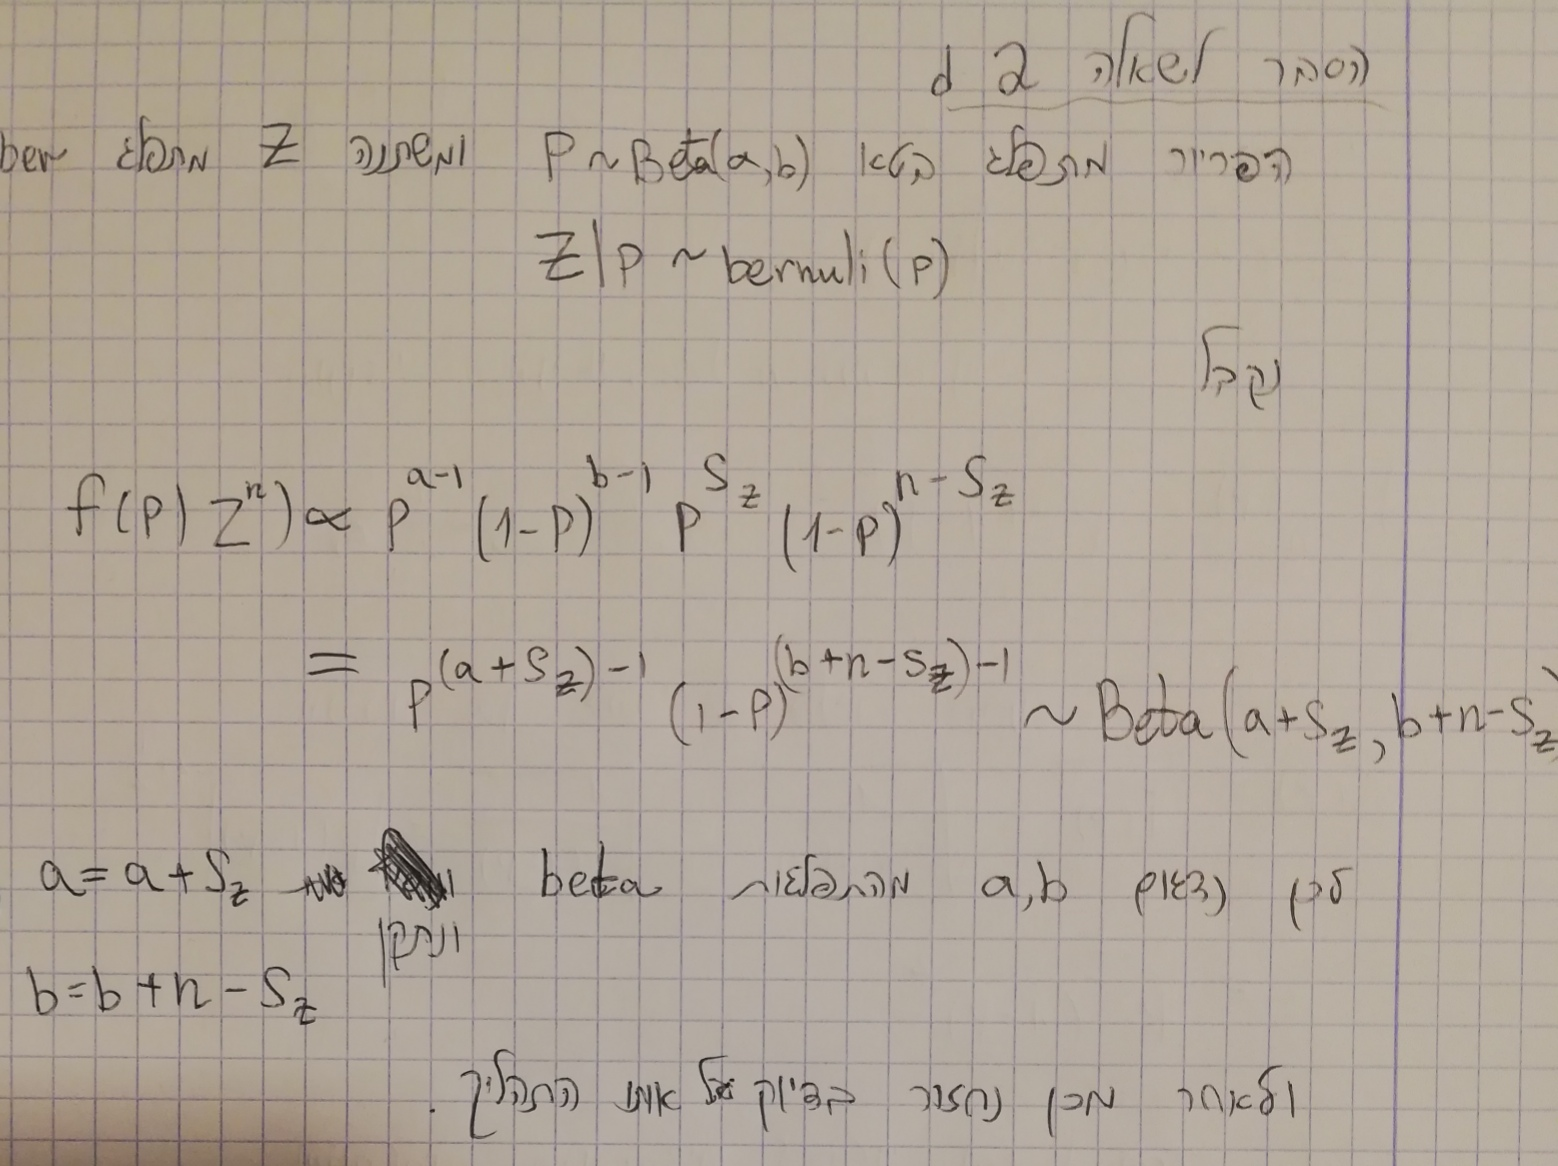

In [ ]:
from scipy.stats import beta

smoker_all = df_1000[df_1000['currentSmoker'] ==1]
no_smoker_all = df_1000[df_1000['currentSmoker']==0]

a_prior_smoke, b_prior_smoke, _,_ = beta.fit(smoker_all['z'])
a_prior_no_smoke, b_prior_no_smoke, _,_ = beta.fit(no_smoker_all['z'])

alpha_smoke = a_prior_smoke + s_smoker
beta_smoke = b_prior_smoke + m - s_smoker

alpha_no_smoke = a_prior_no_smoke + s_no_smoker
beta_no_smoke = b_prior_no_smoke + n - s_no_smoker

all_p_z1_smoke = alpha_smoke/(alpha_smoke + beta_smoke)
all_p_z1_no_smoke = alpha_no_smoke/(alpha_no_smoke + beta_no_smoke)

all_psi = eta(all_p_z1_smoke) - eta(all_p_z1_no_smoke)

#CI
boot_psi =[]
B=400
alpha = 0.05
for i in range(B):
    boot_p_smoker_3 = np.random.beta(alpha_smoke, beta_smoke)
    boot_p_no_smoker_3 = np.random.beta(alpha_no_smoke, beta_no_smoke)
    psi_3 = eta(boot_p_smoker_3) - eta(boot_p_no_smoker_3)
    boot_psi.append(psi_3)

boot_psi.sort()
first_quantile = boot_psi[int(B*alpha/2)]
second_quantile =  boot_psi[int(B*(1-alpha/2))]
ci_3 =[round(first_quantile,3), round(second_quantile,3)]



/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [ ]:
print("Prior estimated - Results:")
print ("Psi value is: ", round(all_psi,3))
print("CI for Psi (with quantiles method) is: ",ci_3)

Prior estimated - Results:
Psi value is:  -0.654
CI for Psi (with quantiles method) is:  [-1.258, -0.016]


question 2. e

ערכי פסיי שהתקבלו מאוד קרובים זה לזה.
 בפלט הראשון ללא בוטסטראפ יש רנדומליות ולכן קיבענו סיד. ערכי הבוטסטראפ הם ממוצע ורואים שהם מתכנסים בכל אחת מהשיטות למספרים קרובים מאוד.
את הקירבה בערכי התוצאות ניתן להסביר בכך שבכולן הפוסטריור מהתפלגות בטא עם פרמטרים די קרובים ולכן באופן טבעי ערכי פסיי קרובים.

במדגם הבוטסטראפ הראשון - ללא הנחת פריור קיבלנו רווחי מהימנות שהכילו את 0.
(תוצאה זו חזרה עבור ערכי סידים שונים)
במדגמים הבאים שהתבססו על גישה בייסיאנית קיבלנו רווחי מהימנות שלא הכילו את ה0.

אורכי רווחי המהימנות די קרובים, כלומר הגישה הבייסיאנית הובילה לתוצאות מובהקות יותר.
נראה שהנחת הפריור מכניסה אינפורציה למודל שמשפיעה על רווחי המהימנות.

In [ ]:
%%shell
jupyter nbconvert --to html /content/ProjectEx5_316299098_316508126.ipynb

[NbConvertApp] Converting notebook /content/ProjectEx5_316299098_316508126.ipynb to html
[NbConvertApp] Writing 1071986 bytes to /content/ProjectEx5_316299098_316508126.html
